# DEA CoastLines validation

## Load modules/functions


In [187]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def interp_intercept(x, y1, y2, reverse=True):
    """Find the intercept of two curves, given by the same x data"""
    
    def intercept(point1, point2, point3, point4):
        """find the intersection between two lines
        the first line is defined by the line between point1 and point2
        the first line is defined by the line between point3 and point4
        each point is an (x,y) tuple.

        So, for example, you can find the intersection between
        intercept((0,0), (1,1), (0,1), (1,0)) = (0.5, 0.5)

        Returns: the intercept, in (x,y) format
        """    

        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C

        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]

            x = Dx / D
            y = Dy / D
            return x,y

        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])

        R = intersection(L1, L2)

        return R

    try:
        
        if isinstance(y2, (int, float)):

            y2 = np.array([y2] * len(x))

        if reverse:

            x = x[::-1]
            y1 = y1[::-1]
            y2 = y2[::-1]

        idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
        xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), 
                           ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))

        return xc[0][0]
    
    except: 
        
        return np.nan

## Pre-processing

### NSW Beach Profile Database



In [201]:
# Select file
fname = glob.glob('/g/data/r78/rt1527/dea-notebooks/MAHTS/validation/input_data/nswbpd/*.csv')[34]

# Read in data
profiles_df = pd.read_csv(fname, skiprows=5)
profiles_df['Year/Date'] = pd.to_datetime(profiles_df['Year/Date'],
                                          dayfirst=True,
                                          errors='coerce')

# Restrict to post 1987
profiles_df = profiles_df[profiles_df['Year/Date'] > '1987']

# Convert columns to strings and add unique ID column
profiles_df['Beach'] = profiles_df['Beach'].str.lower().str.replace(' ', '')
profiles_df['Block'] = profiles_df['Block'].astype(str).str.lower()
profiles_df['Profile'] = profiles_df['Profile'].astype(str).str.lower()
profiles_df['site'] = profiles_df[['Beach', 'Block',
                                   'Profile']].apply('_'.join, 1)

# Rename columns
profiles_df.columns = ['beach', 'section', 'profile', 'date', 'chainage', 
                       'elevation', 'easting', 'northing', 'source', 'site']

# Compute origin points for each profile
start_xy = profiles_df.loc[profiles_df.groupby(['site']).chainage.idxmin(), 
                            ['site', 'easting', 'northing']]
start_xy = start_xy.rename({'easting': 'start_x', 'northing': 'start_y'}, axis=1)
start_xy = start_xy.reset_index(drop=True)

# Compute end points for each profile
end_xy = profiles_df.loc[profiles_df.groupby(['site']).chainage.idxmax(), 
                         ['site', 'easting', 'northing']]
end_xy = end_xy.rename({'easting': 'end_x', 'northing': 'end_y'}, axis=1)
end_xy = end_xy.reset_index(drop=True)

# Join origin and end points into dataframe
profiles_df = pd.merge(left=profiles_df, right=start_xy)
profiles_df = pd.merge(left=profiles_df, right=end_xy)

# Find location and distance to water for datum height (0 m AHD)
out = (profiles_df.groupby(['site', 'date']).apply(lambda x: pd.Series({
          '0_dist': interp_intercept(x.chainage.values, x.elevation.values, 0),
          '0_x': interp_intercept(x.easting.values, x.elevation.values, 0,),
          '0_y': interp_intercept(x.northing.values, x.elevation.values, 0)})))

# Join into dataframe
shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(out)

# Drop null rows and keep required columns
shoreline_dist = shoreline_dist.reset_index().dropna()
shoreline_dist = shoreline_dist[['site', 'beach', 'section', 'profile', 'date', 
                                 'source', 'start_x', 'start_y', 'end_x', 
                                 'end_y', '0_dist', '0_x', '0_y']]

# Export to file
shoreline_dist.to_csv(f'output_data/nswbpd_{shoreline_dist.beach.iloc[0]}.csv', index=False)

# Print output
shoreline_dist.head()

,site,beach,section,profile,date,source,start_x,start_y,end_x,end_y,0_dist,0_x,0_y
0,stockton_a_1,stockton,a,1,1991-08-11,Stereo photogrammtery,386897.94,6357305.07,387142.46,6357432.08,253.394807,387122.744020,6.357422e+06
1,stockton_a_1,stockton,a,1,1994-06-21,Stereo photogrammtery,386897.94,6357305.07,387142.46,6357432.08,253.605887,387122.939481,6.357422e+06
2,stockton_a_1,stockton,a,1,1996-12-01,Stereo photogrammtery,386897.94,6357305.07,387142.46,6357432.08,251.360833,387120.939015,6.357421e+06
3,stockton_a_1,stockton,a,1,1999-09-19,Stereo photogrammtery,386897.94,6357305.07,387142.46,6357432.08,256.948318,387125.897131,6.357423e+06
4,stockton_a_1,stockton,a,1,2001-01-03,Stereo photogrammtery,386897.94,6357305.07,387142.46,6357432.08,257.812178,387126.673135,6.357424e+06


## Analysis

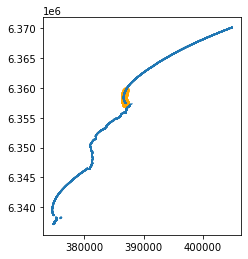

In [234]:
from shapely.geometry import box
import geopandas as gpd

# Load validation data
shoreline_dist = pd.read_csv(f'output_data/nswbpd_stockton.csv', parse_dates=['date'])

# Get bounding box to load data for
minx, maxy = shoreline_dist.min().loc[['0_x', '0_y']]
maxx, miny = shoreline_dist.max().loc[['0_x', '0_y']]
bbox = gpd.GeoSeries(box(minx, miny, maxx, maxy), crs='EPSG:28356')

# Import corresponding waterline contours
contours_gdf = gpd.read_file(f'../packages/DEACoastLines_v0.2.0/DEACoastLines_coastlines_v0.2.0.shp', 
                             bbox=bbox).to_crs(epsg=28356) 
contours_gdf['year'] = contours_gdf.year.astype('int64')

# Plot data
contours_gdf.plot()
test.plot(ax=plt.gca(), c='orange')

0     1988
1     1989
2     1990
3     1991
4     1992
5     1993
6     1994
7     1995
8     1996
9     1997
10    1998
11    1999
12    2000
13    2001
14    2002
15    2003
16    2004
17    2005
18    2006
19    2007
20    2008
21    2009
22    2010
23    2011
24    2012
25    2013
26    2014
27    2015
28    2016
29    2017
30    2018
Name: year, dtype: int64

In [217]:
# test = gpd.GeoDataFrame(data=shoreline_dist, 
#                  geometry=gpd.points_from_xy(x=shoreline_dist['0_x'], y=shoreline_dist['0_y']),
#                  crs='EPSG:28356')
# bbox.to_file('test_bbox.shp')
# test.to_file('test.shp')

In [235]:
# Add year column
shoreline_dist['year'] = shoreline_dist.date.dt.year

# Aggregate by year and save count number
counts = shoreline_dist.groupby(['year', 'site']).count().date
shoreline_dist = shoreline_dist.groupby(['year', 'site']).median()
shoreline_dist['n'] = counts
shoreline_dist = shoreline_dist.reset_index()

In [236]:
from shapely.geometry import Point, LineString

shoreline_geometry = shoreline_dist.apply(lambda x: 
                                           LineString([Point(x.start_x, x.start_y), 
                                                       Point(x.end_x, x.end_y)]), axis=1)

shoreline_gdf = gpd.GeoDataFrame(shoreline_dist, 
                                 geometry=shoreline_geometry, 
                                 crs='EPSG:28356').reset_index()
# shoreline_gdf.to_file('transects.shp')


In [251]:
# Combine to match each shoreline contour to each date in validation data
merge_test = shoreline_gdf.merge(contours_gdf, on='year', suffixes=('_val', '_deacl'))

In [252]:
# For each row, compute distance between origin and location where profile intersects with waterline contour
merge_test['Landsat beach width (m)'] = merge_test.apply(lambda x: x.geometry_val.intersection(x.geometry_deacl).hausdorff_distance(Point(x.start_x, x.start_y)), axis=1)
merge_test = merge_test.rename({'0_dist': 'Validation beach width (m)'}, axis=1)
merge_test = merge_test[merge_test['Landsat beach width (m)'] > 0]
merge_test = merge_test[merge_test['Validation beach width (m)'] > 0]

NameError: name 'collection' is not defined

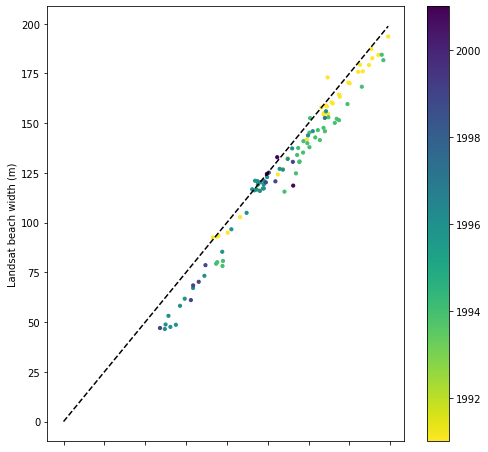

In [249]:
from sklearn.metrics import mean_squared_error

# # Plot
# # merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + 25
# rmse = np.round(mean_squared_error(merge_test['Validation beach width (m)'], merge_test['Landsat beach width (m)'])**0.5, 2)
# cor = np.round(merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].corr().iloc[0, 1], 2)
# dist_lim = merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].max(axis=0).max()
# merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].plot.scatter(x='Validation beach width (m)', 
#                                                                                    y='Landsat beach width (m)', 
#                                                                                    c=merge_test.year, s=10, cmap='viridis_r', figsize=(8, 8))  
# plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')
# plt.title(f'{collection}, {metric} = {metric_thresh} \nRMSE: {rmse} m\nCorrelation: {cor}')
# # plt.savefig(f"{site}_{collection.lower().replace(' ', '')}_{metric}_{metric_thresh}.png")

In [ ]:


# Create geometry for shoreline transects
# shoreline_ahd0_geometry  = shoreline_ahd0.apply(lambda x: LineString([Point(x.origin_x, x.origin_y), Point(x.end_x, x.end_y)]), axis = 1)
shoreline_ahd0_geometry  = shoreline_ahd0.apply(lambda x: LineString([Point(x.foredune_x, x.foredune_y), 
                                                                      Point(x.end_x, x.end_y)]), axis = 1)
shoreline_ahd0_gdf = gpd.GeoDataFrame(shoreline_ahd0, geometry=shoreline_ahd0_geometry).reset_index()
shoreline_ahd0_gdf.crs = 'EPSG:28356'

# Combine to match each shoreline contour to each date in validation data
merge_test = shoreline_ahd0_gdf.merge(contours_gdf, on='year')

# For each row, compute distance between origin and location where profile intersects with waterline contour
merge_test['Landsat beach width (m)'] = merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y).hausdorff_distance(Point(x.origin_x, x.origin_y)), axis=1)
merge_test = merge_test.rename({'ahd0.5_dist': 'Validation beach width (m)'}, axis=1)
merge_test = merge_test[merge_test['Landsat beach width (m)'] > 0]
merge_test = merge_test[merge_test['Validation beach width (m)'] > 0]

# Optional adjustment for tides
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + merge_test['adj_0.10'] 

# Compute difference
merge_test['Difference'] = merge_test['Validation beach width (m)'] - merge_test['Landsat beach width (m)'] 

merge_test = merge_test[merge_test['Landsat beach width (m)'] < 200]
merge_test = merge_test[merge_test['Validation beach width (m)'] < 200]
merge_test = merge_test[merge_test.n > 0]
merge_test.head()


# Plot
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + 25
rmse = np.round(mean_squared_error(merge_test['Validation beach width (m)'], merge_test['Landsat beach width (m)'])**0.5, 2)
cor = np.round(merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].corr().iloc[0, 1], 2)
dist_lim = merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].max(axis=0).max()
merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].plot.scatter(x='Validation beach width (m)', 
                                                                                   y='Landsat beach width (m)', 
                                                                                   c=merge_test.year, s=10, cmap='viridis_r', figsize=(8, 8))  
plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')
plt.title(f'{collection}, {metric} = {metric_thresh} \nRMSE: {rmse} m\nCorrelation: {cor}')
plt.savefig(f"{site}_{collection.lower().replace(' ', '')}_{metric}_{metric_thresh}.png")

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2020